## Data Analysis Calculations with EMRI Kludge Suite

A simple tutorial for the Black Hole Perturbation Toolkit Spring 2020 Workshop (Virtual)

**Alvin Chua (JPL-Caltech)**  
**Michael Katz (Northwestern)**

#### INSTALLATION

The standard GSL and FFTW libraries are required for installation. On Ubuntu:

```sudo apt-get install gsl-bin```  
```sudo apt-get install libfftw3-dev```

On OSX:

```brew install gsl```  
```brew install fftw```

Manual installation:

https://www.gnu.org/software/gsl/  
http://www.fftw.org/download.html

The EMRI Kludge Suite itself is hosted on GitHub. To download:

```git clone https://github.com/alvincjk/EMRI_Kludge_Suite.git```

To install:

```make ```  
```python setup.py install```

#### IMPORTS

In [1]:
import numpy as np
from SNR_tutorial_utils import LISA_Noise
from SNR_tutorial_utils import AAK_Wave

import matplotlib.pyplot as plt
%matplotlib inline

#### LISA NOISE CURVE

The function LISA_Noise(f) is an analytic fit to the LISA noise curve (arXiv:1803.01944). It describes the power spectral density S_n of a stochastic process, so it has units of 1/Hz. The fit comprises instrumental noise and estimated "confusion" noise from a foreground of unresolved Galactic binaries. Confusion noise is reduced as the mission progresses and more foreground sources are resolved. Noise curves with various foreground estimates are plotted using the cell below; we will take the estimate after 4 years (the planned mission lifetime) as a default.

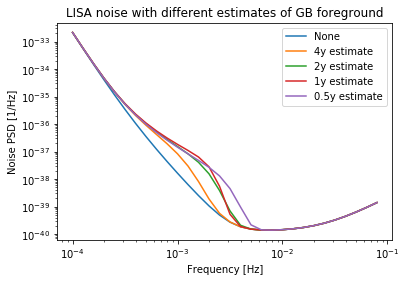

In [2]:
plot_freqs = 10**np.arange(-4,-1,0.1)

plot_noise = [
    LISA_Noise(plot_freqs,conf=False),
    LISA_Noise(plot_freqs),
    LISA_Noise(plot_freqs,dur=2),
    LISA_Noise(plot_freqs,dur=1),
    LISA_Noise(plot_freqs,dur=0.5)
    ]

for i in range(len(plot_noise)):
    plt.plot(plot_freqs,plot_noise[i])
plt.xscale('log')
plt.yscale('log')
plt.legend(['None','4y estimate','2y estimate','1y estimate','0.5y estimate'])
plt.title('LISA noise with different estimates of GB foreground')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Noise PSD [1/Hz]')
plt.show()

#### AAK WAVEFORM

The function AAK_Wave(mu, M, a, p0, e0, i0, D) generates an augmented analytic kludge waveform (arXiv:1705.04259). It takes as input the *detector-frame* component masses (mu, M) in Solar masses, the Kerr spin parameter a/M, the initial quasi-Keplerian orbital parameters (p0/M, e0, i0), and the luminosity distance D in Gpc. Note that detector-frame masses are larger than source-frame masses by less than a factor of 3 at typical luminosity distances for observable EMRIs (<10 Gpc). AAK_Wave describes the two GW polarization modes at the location of the Solar System barycenter over a ~1-year duration; specifically, its output is a NumPy array [timestamp, h_plus, h_cross] containing time series with length 3e6 and sampling rate 0.1 Hz (hard-coded for this tutorial).

Now let's generate a waveform with some given parameters that describe a "typical" observable EMRI:

In [3]:
%%time
wave1 = AAK_Wave(mu=1e1,M=1e6,a=0.5,p0=8,e0=0.1,i0=np.pi/6,D=5)

CPU times: user 22.5 s, sys: 231 ms, total: 22.8 s
Wall time: 22.6 s


We're working with the vanilla time-domain version of the AAK, so that took a while. Faster versions of the AAK are available, depending on your specific application or available hardware. Let's look at the first hour of the waveform:

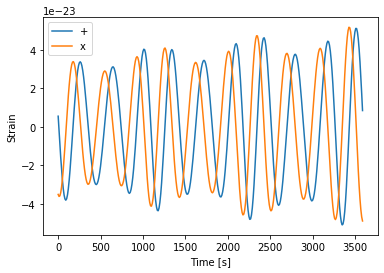

In [4]:
plt.plot(wave1[0][:360],wave1[1][:360])
plt.plot(wave1[0][:360],wave1[2][:360])
plt.legend(['+','x'])
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.show()

And the full waveform, but just the plus mode:

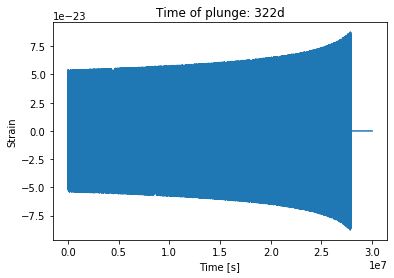

In [5]:
plt.plot(wave1[0],wave1[1])
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.title(f'Time of plunge: {int(np.sum(wave1[1]!=0)/8640)}d')
plt.show()

The EMRI plunges after 322 days (approximately, since this is a kludge waveform). That's partly why we've chosen these particular parameters - so we can calculate the SNR for ~1 year of observation just before plunge. 

#### CALCULATING SNR

We'll need a fast Fourier transform, which NumPy provides; the relevant function is np.fft.rfft(real vector). Recall that the sampling parameters are:

In [9]:
N = int(3e6)
dt = 10
T = N*dt
df = 1/T

Let Waveform 1 be the signal we've just generated. Using the equations given below, try to calculate the optimal expected SNR for Waveform 1 by yourself:

$\langle a_{+,\times}(t)|b_{+,\times}(t)\rangle=4\Re\left[\sum_{f>0}^{f_\mathrm{max}}df\,\frac{\tilde{a}_+(f)^*\tilde{b}_+(f)+\tilde{a}_\times(f)^*\tilde{b}_\times(f)}{S_n(f)}\right]$

$\mathrm{SNR}(a_{+,\times})=\sqrt{\langle a_{+,\times}|a_{+,\times}\rangle}$

In [19]:
hp = wave1[1]
hc = wave1[2]

hp_f, hc_f = np.fft.rfft(hp)[1:]*dt, np.fft.rfft(hc)[1:]*dt

freqs = np.fft.rfftfreq(N, d=dt)[1:]

snr_square = 4*df*np.real(np.sum((hp_f.conj()*hp_f + hc_f.conj()*hc_f)/LISA_Noise(freqs)))

print(snr**(1/2))



22.417683351520115


There are three things to look out for when taking FFTs. The first is the Fourier transform convention. Data analysis expressions use the *unnormalized* transform, which also happens to be the default in NumPy and other popular libraries like FFTW, so we don't have to do anything here. (But note that Mathematica gives the unitary transform by default.) The second is the output format; np.fft.rfft returns only the floor(n/2)+1 positive-frequency components, since the discrete Fourier transform of a real signal is Hermitian symmetric. Similar functions in other libraries may not do the same thing. The third, and most frequently overlooked, is *dimensions*. The Fourier transform of a dimensionless time series has units of time, while its DFT remains dimensionless; this difference comes from the delta in the Riemann sum when using a DFT to approximate a Fourier transform. In other words, the FFT and its frequency grid must be adjusted with units of dt:

In [15]:
wave1f = np.fft.rfft(wave1[1:3])*dt
fft_freqs = np.fft.rfftfreq(N)/dt

We've defined the inner product and SNR functions here, so you can use them in the rest of the notebook:

In [16]:
def inner(h1f, h2f):
    plus = np.conj(h1f[0,1:])@(h2f[0,1:]/LISA_Noise(fft_freqs[1:]))
    cross = np.conj(h1f[1,1:])@(h2f[1,1:]/LISA_Noise(fft_freqs[1:]))
    return 4*df*np.real(plus+cross)

def SNR(hf):
    return np.sqrt(inner(hf,hf))

This is the correct value of SNR for Waveform 1:

In [17]:
SNR(wave1f)

22.417683351520086

It's just above the SNR threshold for statistically establishing a robust detection (~15-20, depending on the exact procedure). One way to visualize SNR is to plot the *characteristic strain* h_c and *characteristic noise* h_n together; these dimensionless quantities are essentially the waveform and noise amplitudes at each frequency, but weighted appropriately by frequency. The area between h_c and h_n on a log-log plot then gives a visual indication (but not an approximation) of SNR. We've defined both here, so you can use them in the rest of the notebook:

In [20]:
freq_mask = np.where(fft_freqs>1e-4)[0]

char_noise = np.sqrt(fft_freqs[freq_mask]*LISA_Noise(fft_freqs[freq_mask]))

def char_strain(hf):
    return 2*fft_freqs[freq_mask]*np.sqrt(np.abs(hf[0,freq_mask])**2+np.abs(hf[1,freq_mask])**2)

Here's the characteristic strain/noise plot for Waveform 1:

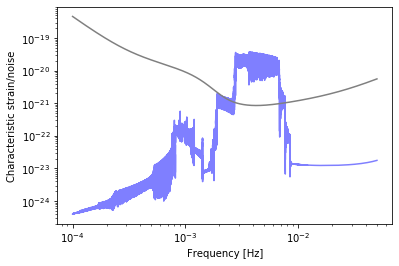

In [65]:
plt.plot(fft_freqs[freq_mask],char_strain(wave1f),c='b',alpha=0.5)
plt.plot(fft_freqs[freq_mask],char_noise,c='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic strain/noise')
plt.show()

#### INITIAL SEPARATION

Let's generate Waveform 2, for a source with the same parameters as before but starting at 12M instead:

In [22]:
%%time
wave2 = AAK_Wave(mu=1e1,M=1e6,a=0.5,p0=12,e0=0.1,i0=np.pi/6,D=5)

CPU times: user 24.7 s, sys: 249 ms, total: 25 s
Wall time: 24.8 s


It has fewer cycles in the first hour, as expected:

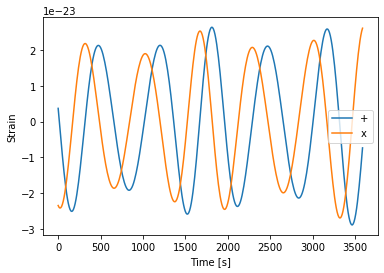

In [23]:
plt.plot(wave2[0][:360],wave2[1][:360])
plt.plot(wave2[0][:360],wave2[2][:360])
plt.legend(['+','x'])
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.show()

Let's calculate the optimal expected SNR for Waveform 2:

In [24]:
wave2f = np.fft.rfft(wave2[1:3])*dt
SNR(wave2f)

2.2908987920120234

A slightly surprising result, perhaps. The characteristic strain/noise plot might explain what's going on:

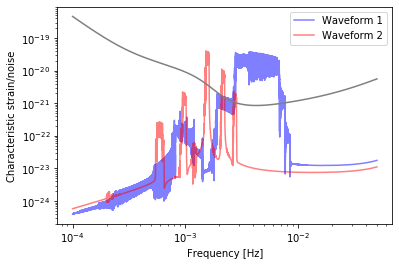

In [73]:
plt.plot(fft_freqs[freq_mask],char_strain(wave1f),c='b',alpha=0.5)
plt.plot(fft_freqs[freq_mask],char_strain(wave2f),c='r',alpha=0.5)
plt.plot(fft_freqs[freq_mask],char_noise,c='gray')
plt.xscale('log')
plt.yscale('log')
plt.legend(['Waveform 1','Waveform 2'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic strain/noise')
plt.show()

Waveform 2 sits higher on the left slope of the noise curve, and its frequencies evolve less over a year. To achieve the same 1-year SNR, you'd need the source to be 10 times nearer, which is a lot less likely in an astrophysical sense. But at the same time, this signal will remain in the LISA band and has a chance of building up enough SNR within the mission lifetime to be detected.

#### INITIAL ECCENTRICITY

Let's generate Waveform 3, for a source with the same parameters as Waveform 1 but an initial eccentricity of 0.4:

In [26]:
%%time
wave3 = AAK_Wave(mu=1e1,M=1e6,a=0.5,p0=8,e0=0.4,i0=np.pi/6,D=5)

CPU times: user 1min 6s, sys: 384 ms, total: 1min 6s
Wall time: 1min 6s


The AAK model relies on a frequency-based decomposition into harmonic modes; at higher eccentricity, more modes contribute significantly to the overall power in the waveform. As a result, generating Waveform 3 takes about 3 times longer than Waveform 1, even though the time of plunge is similar:

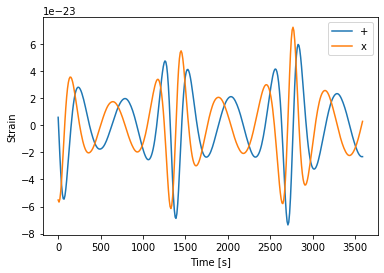

In [29]:
plt.plot(wave3[0][:360],wave3[1][:360])
plt.plot(wave3[0][:360],wave3[2][:360])
plt.legend(['+','x'])
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.show()

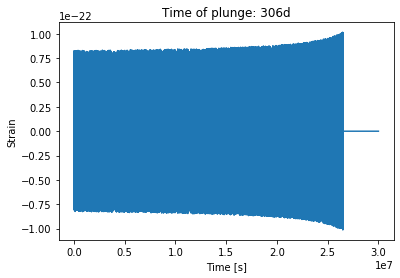

In [30]:
plt.plot(wave3[0],wave3[1])
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.title(f'Time of plunge: {int(np.sum(wave3[1]!=0)/8640)}d')
plt.show()

As expected, the modulations from the contribution of higher-frequency modes are more pronounced now:

With all other conditions (including the length of actual signal) being similar, let's look at the effect of eccentricity on SNR:

In [31]:
wave3f = np.fft.rfft(wave3[1:3])*dt
SNR(wave3f)

20.348073318288034

It doesn't have a large effect. The characteristic strain/noise plot shows that Waveform 3 has a larger bandwidth than Waveform 1, but at the same time the overall power is more "smeared out" (the characteristic strain has a wider envelope at intermediate frequencies): 

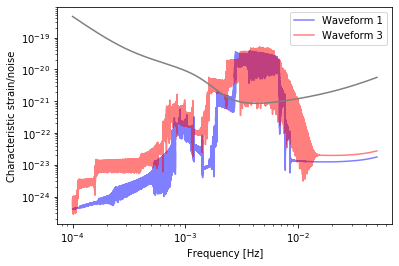

In [33]:
plt.plot(fft_freqs[freq_mask],char_strain(wave1f),c='b',alpha=0.5)
plt.plot(fft_freqs[freq_mask],char_strain(wave3f),c='r',alpha=0.5)
plt.plot(fft_freqs[freq_mask],char_noise,c='gray')
plt.xscale('log')
plt.yscale('log')
plt.legend(['Waveform 1','Waveform 3'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic strain/noise')
plt.show()

#### MASS RATIO

Let's generate Waveform 4, for a source with the same parameters as Waveform 1 but a mass ratio of 1e-4 (fixing the primary mass):

In [74]:
%%time
wave4 = AAK_Wave(mu=1e2,M=1e6,a=0.5,p0=8,e0=0.1,i0=np.pi/6,D=5)

CPU times: user 2.92 s, sys: 185 ms, total: 3.11 s
Wall time: 2.99 s


That went much faster than before, because the EMRI plunges early:

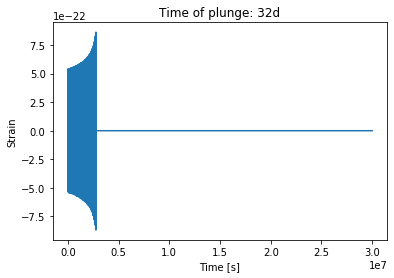

In [75]:
plt.plot(wave4[0],wave4[1])
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.title(f'Time of plunge: {int(np.sum(wave4[1]!=0)/8640)}d')
plt.show()

We'll need to increase the initial separation to get a longer signal, so we can look at the final-year SNR. Note that this doesn't give the same EMRI earlier in time, since we're not changing the initial eccentricity and inclination accordingly. Tweak p0 such that the EMRI plunges after 300-330 days, then calculate the SNR:

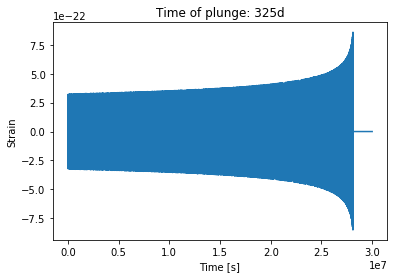

In [43]:
wave4 = AAK_Wave(mu=1e2,M=1e6,a=0.5,p0=13.3,e0=0.1,i0=np.pi/6,D=5)
plt.plot(wave4[0],wave4[1])
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.title(f'Time of plunge: {int(np.sum(wave4[1]!=0)/8640)}d')
plt.show()

In [48]:
wave4f = np.fft.rfft(wave4[1:3])*dt
SNR(wave4f)

83.02136072906514

Increasing the initial separation to around 13.3M should do the job; this has the effect of lowering the starting frequency. The amplitude of the signal is also increased due to the larger secondary mass. Both factors lead to a significant boost in SNR:

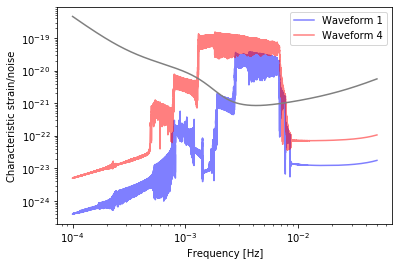

In [49]:
plt.plot(fft_freqs[freq_mask],char_strain(wave1f),c='b',alpha=0.5)
plt.plot(fft_freqs[freq_mask],char_strain(wave4f),c='r',alpha=0.5)
plt.plot(fft_freqs[freq_mask],char_noise,c='gray')
plt.xscale('log')
plt.yscale('log')
plt.legend(['Waveform 1','Waveform 4'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic strain/noise')
plt.show()

Q: Will a similar EMRI with a secondary of 1 Solar mass be detectable in the last year before plunge?

#### TOTAL MASS

Let's generate Waveform 5, for a source with the same parameters (and mass ratio) as Waveform 1 but a primary of 1e5 Solar masses:

In [57]:
%%time
wave5 = AAK_Wave(mu=1e0,M=1e5,a=0.5,p0=8,e0=0.1,i0=np.pi/6,D=5)

CPU times: user 2.89 s, sys: 174 ms, total: 3.06 s
Wall time: 2.97 s


The EMRI plunges after 32 days - the same amount of time as in Waveform 4 (with the original value of p0):

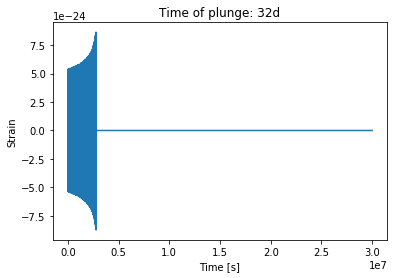

In [58]:
plt.plot(wave5[0],wave5[1])
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.title(f'Time of plunge: {int(np.sum(wave5[1]!=0)/8640)}d')
plt.show()

Q: Why is the time of plunge the same? Is this waveform identical (at leading order) to the original Waveform 4?

Let Waveform 5 be for a primary of 1e7 Solar masses instead, again keeping the original mass ratio of 1e-5. Now the initial separation of 8M is too large, and the EMRI is over a year from plunge. Tweak p0 such that the EMRI plunges after 300-330 days, then calculate the final-year SNR:

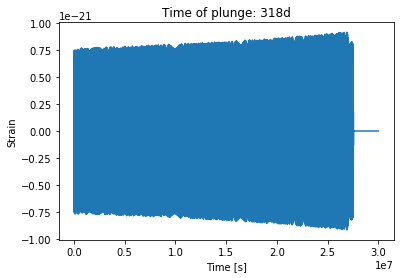

5.2347971818297845

In [59]:
wave5 = AAK_Wave(mu=1e2,M=1e7,a=0.5,p0=5.6,e0=0.1,i0=np.pi/6,D=5)

plt.plot(wave5[0],wave5[1])
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.title(f'Time of plunge: {int(np.sum(wave5[1]!=0)/8640)}d')
plt.show()


wave5f = np.fft.rfft(wave5[1:3])*dt
SNR(wave5f)



Decreasing the initial separation to around 5.6M should do the job. However, the starting frequency is still lowered overall since the primary mass is 10 times larger than in the source for Waveform 1. The amplitude of the signal is again increased due to the larger secondary mass, but the higher noise at lower frequencies means that the SNR is now sub-threshold:

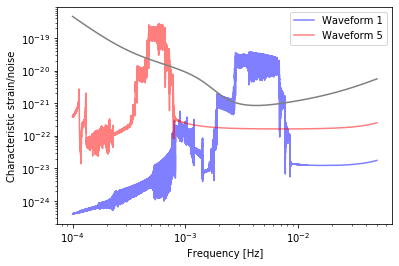

In [64]:
plt.plot(fft_freqs[freq_mask],char_strain(wave1f),c='b',alpha=0.5)
plt.plot(fft_freqs[freq_mask],char_strain(wave5f),c='r',alpha=0.5)
plt.plot(fft_freqs[freq_mask],char_noise,c='gray')
plt.xscale('log')
plt.yscale('log')
plt.legend(['Waveform 1','Waveform 5'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic strain/noise')
plt.show()

#### PRIMARY SPIN

Let's generate two waveforms this time, for a source with the same parameters as Waveform 1 but different primary spins. Consider a Schwarzschild primary for the first source; increase the initial separation to 8.8M, in order to account for an earlier time of plunge (as the last stable orbit has shifted outwards). Let the second source have a primary spin of 0.9; decrease the initial separation to 7.2M such that this EMRI plunges after the same amount of time as the first. Calculate the SNR for both waveforms, and produce a characteristic strain/noise plot for each:

In [62]:
wave6 = AAK_Wave(mu=1e1,M=1e6,a=0.0,p0=8.8,e0=0.1,i0=np.pi/6,D=5)
wave7 = AAK_Wave(mu=1e1,M=1e6,a=0.9,p0=7.2,e0=0.1,i0=np.pi/6,D=5)

wave6f = np.fft.rfft(wave6[1:3])*dt
snr6 = SNR(wave6f)

wave7f = np.fft.rfft(wave7[1:3])*dt
snr7 = SNR(wave7f)

print(snr6, snr7)

14.869200145684024 27.27886086553212


Q: Does SNR vary strongly with the spin of the primary? Is the variation due to the direct effect of spin on the waveform?